In [18]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import os

### Embedding symbols in pictures

In [19]:
# function that returns more "realistic" symbol placement on the background plan image

def position_symbol_near_line(overlay_shape, background_array, theta, line_length):
    max_counter = 5000
    edge_width = 1
    padding = 5
    edge_thres = 120
    overlap_thres = 240

    ow = overlay_shape[0]
    oh = overlay_shape[1]

    bckw = background_array.shape[1]
    bckh = background_array.shape[0]
    
    counter = 0
    while True:
        counter += 1
        x = random.randint( (0 + line_length), (bckw - ow - edge_width - line_length) )
        y = random.randint( (0 + line_length), (bckh - oh - edge_width - line_length) )


        if theta == 0:
            val = background_array[(y+oh):(y+oh+edge_width), (x-line_length):(x+ow+line_length), :].mean()
        elif theta == 90:
            val = background_array[y-line_length:y+oh+line_length, (x+ow):(x+ow+edge_width), :].mean()
        elif theta == 180:
            val = background_array[y:(y+edge_width), x-line_length:x+ow+line_length, :].mean()
        else:
            val = background_array[y-line_length:y+oh+line_length, x:(x+edge_width), :].mean()

        cov = background_array[y-padding:y+oh+padding, x-padding:x+ow+padding, :].mean()

        if (val < edge_thres) and (cov > overlap_thres): # first condition "ties" the symbol to a horizontal or vertical line, 2nd condition makes sure it's overlayed on a mostly empty background
            return x, y
        elif counter == max_counter:
            return -1, -1



def get_label(overlay_filename):
    if "duplex" in overlay_filename:
        return 0
    if "quad" in overlay_filename:
        return 1
    if "special" in overlay_filename:
        return 2
    if "switch" in overlay_filename:
        return 3
    

In [20]:
def generate_training_data():
    symbols_folder = '../data/auto_generated_symbols/'
    drawings_folder = '../data/plans/without_symbols/'
    output_folder = '../data/auto_generated_training/_temp_output_dir/'
    output_image_size = 512
    num_symbols_to_overlay = random.choice([3,4,5,6,7,8])  # set up the number of symbols to overlay in each image


    # get a list of all the images from both symbols and drawings
    symbol_images = os.listdir(symbols_folder)
    background_images = os.listdir(drawings_folder)

    # select a set of paths to overlay images
    overlay_images = random.choices(symbol_images, k=num_symbols_to_overlay)

    # create a random image patch (background_patch) from a random background image
    background_image_name = random.choice(background_images)
    background_image = Image.open(os.path.join(drawings_folder, background_image_name))
    background_array = np.asarray(background_image)  # convert the image to an array so a patch can be randomized from it
    xpatch = random.randint(0, background_image.width-output_image_size)
    ypatch = random.randint(0, background_image.height-output_image_size)
    patch_array = background_array[ypatch:ypatch+output_image_size, xpatch:xpatch+output_image_size, :]
    background_patch = Image.fromarray(patch_array, 'RGBA')


    yolo_data = '' # add onto this string for each added symbol

    for i, overlay_image in enumerate(overlay_images):

        overlay = Image.open(os.path.join(symbols_folder, overlay_image)).convert('RGB') # open this overlay image. .convert('RGB') ensures that we get three channels
        overlay = overlay.convert('RGBA')  # convert (mostly) white pixels to transparent

        datas = overlay.getdata()
        newData = []
        for item in datas:
            if item[0] >= 230 and item[1] >= 230 and item[2] >= 230: # cutoff of 230 seems to work, has to be lower than 255 
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
        overlay.putdata(newData)


        # resize the overlay to match background drawing size
        overlay_size = max(overlay.size)
        overlay_scale = random.randint(22, 36)/overlay_size
        # overlay_scale = (random.uniform(0.03, 0.06)*output_image_size)/overlay_size
        overlay = overlay.resize((int(overlay.size[0]*overlay_scale), int(overlay.size[1]*overlay_scale)))

        # rotate overlay
        angle = random.choice([0, 90, 180, 270]) # choose a random cardinal direction
        overlay = overlay.rotate(angle, expand=True)

        x, y = position_symbol_near_line(overlay.size, patch_array, theta=angle, line_length=25)
        if x == y == -1:
            num_symbols_to_overlay -= 1
            continue # symbol couldn't be placed on the patch, skip and proceed to next one

        background_patch.paste(overlay, (x, y), overlay)
        patch_array = np.asarray(background_patch)

        # add YOLO bounding box data to string
        x_center = (x + 0.5*overlay.width)/background_patch.width
        y_center = (y + 0.5*overlay.height)/background_patch.height
        width = overlay.width/background_patch.width
        height = overlay.height/background_patch.height
        yolo_data += f'{get_label(overlay_images[i])} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n'

    # print(f"{num_symbols_to_overlay}/{i+1} symbols placed on patch")
    # output_path = os.path.join(output_folder, background_image_name[:-4])

    return output_folder, background_patch, yolo_data

### Test the function

1 0.699219 0.453125 0.046875 0.050781
1 0.130859 0.166016 0.039062 0.042969
1 0.621094 0.704102 0.066406 0.048828
0 0.692383 0.208984 0.064453 0.042969
0 0.080078 0.159180 0.062500 0.044922
1 0.893555 0.134766 0.044922 0.066406



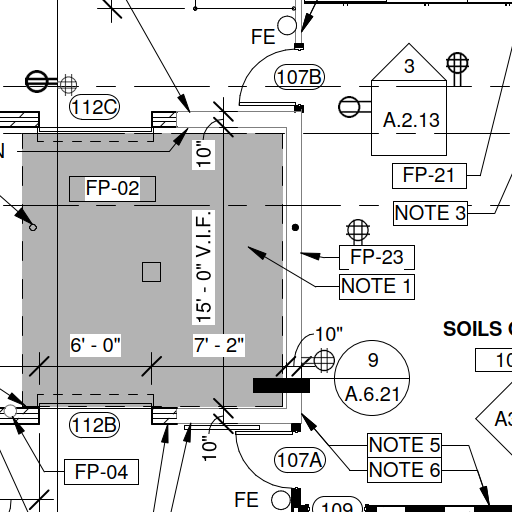

In [21]:
output_path, image_output, yolo_data = generate_training_data()
print(yolo_data)
image_output

In [27]:
for i in range(1,330):
    output_folder, background_patch, yolo_data = generate_training_data()

    if i==1:
        os.makedirs(output_folder+"images/")
        os.makedirs(output_folder+"labels/")

    if yolo_data != "":
        output_path = output_folder + "images/ag_" + str(i).zfill(4) + ".png"
        background_patch.save(output_path)

        output_path = output_folder + "labels/ag_" + str(i).zfill(4) + ".txt"
        with open(output_path, mode="w") as f:
            f.write(yolo_data)

In [28]:
# split into train, valid and test folders
output_dir = output_folder
train_split = 0.5
valid_split = 0.3
test_split = 0.2

os.makedirs(output_dir+"train/images")
os.makedirs(output_dir+"train/labels")
os.makedirs(output_dir+"valid/images")
os.makedirs(output_dir+"valid/labels")
os.makedirs(output_dir+"test/images")
os.makedirs(output_dir+"test/labels")

imagelist = os.listdir(output_dir+"images")
labellist = os.listdir(output_dir+"labels")
n = len(imagelist)
print(f"Partitioning {n} images into train, valid, and test")

idx_set = [i for i in range(0,n)]
idx_train_set = random.sample(idx_set, int(n*train_split))
idx_set = [i for i in idx_set if i not in idx_train_set]
idx_valid_set = random.sample(idx_set, int(n*valid_split))
idx_test_set = [i for i in idx_set if i not in idx_valid_set]

for idx in idx_train_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"train/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"train/labels/"+labellist[idx])
for idx in idx_valid_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"valid/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"valid/labels/"+labellist[idx])
for idx in idx_test_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"test/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"test/labels/"+labellist[idx])

os.rmdir(output_dir+"images/")
os.rmdir(output_dir+"labels/")

Partitioning 312 images into train, valid, and test
